In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# this allows plots to appear directly in the notebook
%matplotlib inline

In [14]:
fuel = pd.read_csv('Fuel Efficiciency/Fuel_FO_2010-17_lr.csv', sep = ';',index_col=None,encoding='latin-1')
fuel.head(5)

,IN,Train_Bulletin,Sector,DateTime1,Id_Loc,Track_id,Id_Engineer,Id_fireman,Hours,Kilometers,...,id_Type,Type,Traccion,Direction,Id_Model_Loc,Model_Loc,UTC,GTK_T,Net_Ton_Km,Liters_r
0,TREN,32175,N,26/4/2017,5409,1,67.0,252.0,4.63,56.1,...,1,CARGA,S,0,38,GE U20C,UTR,35628557.1,56.1,100.0
1,TREN,32177,N,26/4/2017,11,1,104.0,285.0,2.25,35.1,...,1,CARGA,S,1,9,GE U10B,UTR,21194784.0,14995773.0,100.0
2,TREN,32178,N,26/4/2017,5409,1,67.0,252.0,3.08,56.1,...,1,CARGA,S,1,38,GE U20C,UTR,83729250.0,58905000.0,200.0
3,TREN,32187,N,27/4/2017,6931,1,18.0,286.0,1.75,35.1,...,1,CARGA,S,1,43,HM,UTR,20671794.0,14546844.0,50.0
4,TREN,32188,N,27/4/2017,21,1,72.0,91.0,3.33,56.1,...,1,CARGA,S,0,28,GM,UTR,27692100.0,0.0,100.0


In [15]:
#fuel.dtypes

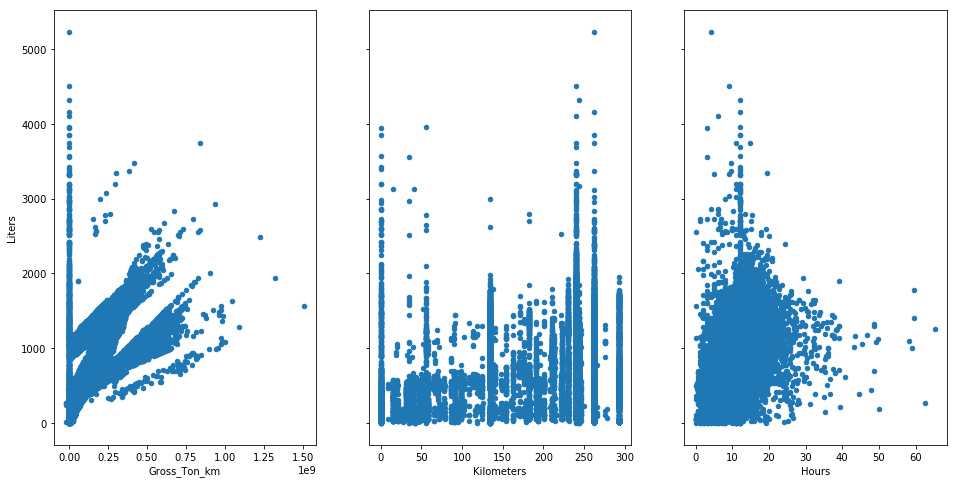

In [16]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 3, sharey=True)
fuel.plot(kind='scatter', x='Gross_Ton_km', y='Liters', ax=axs[0], figsize=(16, 8))
fuel.plot(kind='scatter', x='Kilometers', y='Liters', ax=axs[1])
fuel.plot(kind='scatter', x='Hours', y='Liters', ax=axs[2])

In [17]:
# this is the standard import if you're using "formula notation" (similar to R)
import statsmodels.formula.api as smf

# create a fitted model in one line
lm = smf.ols(formula='Liters ~ Gross_Ton_km', data=fuel).fit()

# print the coefficients
lm.params

Intercept       332.090801
Gross_Ton_km      0.000002
dtype: float64

In [18]:
import numpy as np
# set a seed for reproducibility
np.random.seed(123456)

# assign 70% of data as training
nums = np.random.rand(len(fuel))
mask_test = (nums > 0.70)
fuel['ml_Type'] = 'train'
fuel.loc[mask_test, 'ml_Type'] = 'test'
#fuel.head()

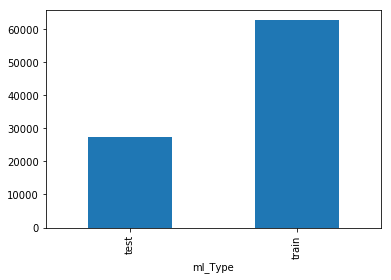

In [19]:

# Show the distribution of Test and Train Data
fuel.groupby(fuel.ml_Type).size().plot(kind='bar')


In [20]:
f = fuel.copy()
# Use Training Data, Filter out Shunting Locomotives, choose only consumption between 40 and 1300 liters, postive GTK, 6 main track, less than two days
f = f[(f.ml_Type == 'train') & (f.Liters >40) & (f.Liters < 1300) & (f.IN == 'TREN') & (f.Gross_Ton_km >0) & (f.Track_id <=6) & (f.Hours < 48)]
# create six dummy variables for track_id using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(f.Track_id, prefix='SD').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
f = pd.concat([f, area_dummies], axis=1)

# create six dummy variables for Locomotive Type using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(f.Model_Loc, prefix='MOD').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
f = pd.concat([f, area_dummies], axis=1)


# create six dummy variables for Locomotive Type using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(f.Sub_Type, prefix='TRN').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
f = pd.concat([f, area_dummies], axis=1)


# create a new Series called IsUnit
f['IsUnit'] = f.UTC.map({'NUT':0, 'UTR':1})

f.head()

,IN,Train_Bulletin,Sector,DateTime1,Id_Loc,Track_id,Id_Engineer,Id_fireman,Hours,Kilometers,...,TRN_CARGA GENERAL,TRN_DERIVADOS DE PETROLEO,TRN_ESPECIAL,TRN_EXPRESO ORIENTAL,TRN_LOCOMOTORA SOLA,TRN_SERVICIO INTERNO,TRN_SOCORRO,TRN_TREN MIXTO AL SUR,TRN_TREN REGIONAL,IsUnit
0,TREN,32175,N,26/4/2017,5409,1,67.0,252.0,4.63,56.1,...,1,0,0,0,0,0,0,0,0,1.0
2,TREN,32178,N,26/4/2017,5409,1,67.0,252.0,3.08,56.1,...,1,0,0,0,0,0,0,0,0,1.0
4,TREN,32188,N,27/4/2017,21,1,72.0,91.0,3.33,56.1,...,1,0,0,0,0,0,0,0,0,1.0
5,TREN,32190,N,27/4/2017,21,1,72.0,91.0,5.05,56.1,...,1,0,0,0,0,0,0,0,0,1.0
6,TREN,32207,N,28/4/2017,22,1,14.0,32.0,3.42,56.1,...,1,0,0,0,0,0,0,0,0,1.0


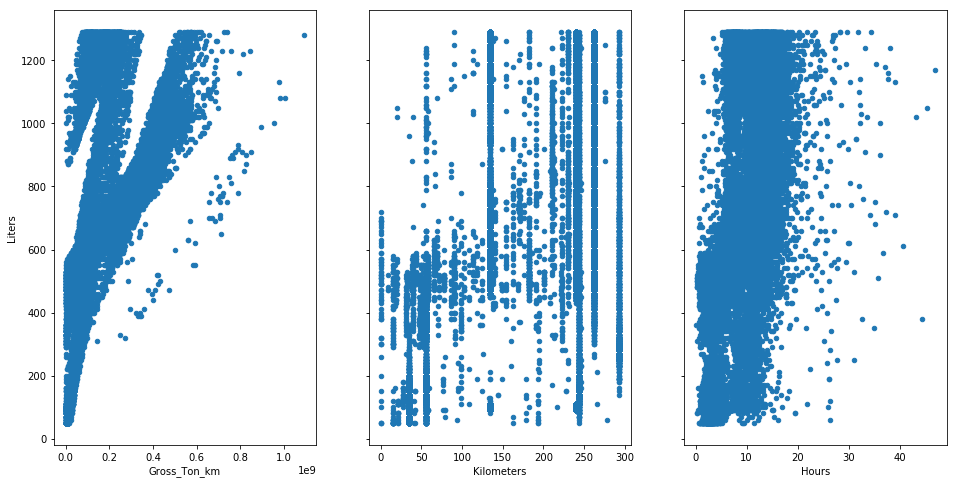

In [21]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 3, sharey=True)
f.plot(kind='scatter', x='Gross_Ton_km', y='Liters', ax=axs[0], figsize=(16, 8))
f.plot(kind='scatter', x='Kilometers', y='Liters', ax=axs[1])
f.plot(kind='scatter', x='Hours', y='Liters', ax=axs[2])

In [22]:
f.dtypes

IN                            object
Train_Bulletin                 int64
Sector                        object
DateTime1                     object
Id_Loc                         int64
Track_id                       int64
Id_Engineer                  float64
Id_fireman                   float64
Hours                        float64
Kilometers                   float64
Liters                         int64
Net_Ton_Km_r                 float64
Gross_Ton_km                 float64
Net_Tons                       int64
Gross_Tons                     int64
Date                          object
Locomotive                     int64
Track                         object
Maquinista                    object
Auxiliar                      object
Train_nbr                     object
Id_Sub_Type                    int64
Sub_Type                      object
id_Type                        int64
Type                          object
Traccion                      object
Direction                      int64
I

In [23]:
# Linear Regression
# create X and y
feature_cols = ['Gross_Ton_km','IsUnit', 'SD_2', 'SD_3', 'SD_4', 'SD_5', 'SD_6']
X = f[feature_cols]
y = f.Liters

# follow the usual sklearn pattern: import, instanti, 'SD_3', 'SD_3'ate, fit
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X, y)

# print coefficients
list(zip(feature_cols, lm.coef_))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# calculate the R-squared
lm.score(X, y)

In [ ]:
# create X and y
feature_cols = ['Gross_Ton_km','IsUnit', 'SD_2', 'SD_3', 'SD_4', 'SD_5', 'SD_6', 'MOD_GE C23EMP', 'MOD_GE U10B', 'MOD_GE U20C', 'MOD_GM', 'MOD_HM', 'TRN_DERIVADOS DE PETROLEO', 'TRN_ESPECIAL', 'TRN_LOCOMOTORA SOLA', 'TRN_SERVICIO INTERNO', 'TRN_SOCORRO']
X = f[feature_cols]
y = f.Liters


# follow the usual sklearn pattern: import, instantiate, fit False
from sklearn.linear_model import LinearRegression
lm = LinearRegression(fit_intercept=False)
lm.fit(X, y)

# print intercept
#print ('Intercept:')
#print (lm.intercept_)

print ('')
# print coefficients
print ('Coefficients:')
list(zip(feature_cols, lm.coef_))


In [ ]:
lm.score(X, y)

In [ ]:
#from sklearn.isotonic import IsotonicRegression
#ir = IsotonicRegression()

#y_ = ir.fit_transform(f.Gross_Ton_km, y)

#lr = LinearRegression(fit_intercept=False)
#lr.fit(X, y)


In [ ]:
# Plot Results
#n = len(f)-1
#segments = [[[i, y[i]], [i, y_[i]]] for i in range(n)]
#lc = LineCollection(segments, zorder=0)
#lc.set_array(np.ones(len(y)))
#lc.set_linewidths(0.5 * np.ones(n))

#fig = plt.figure()
#plt.plot(x, y, 'r.', markersize=12)
#plt.plot(x, y_, 'g.-', markersize=12)
#plt.plot(x, lr.predict(x[:, np.newaxis]), 'b-')
#plt.gca().add_collection(lc)
#plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')
#plt.title('Isotonic regression')
#plt.show()

# create six dummy variables for track_id using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(fuel.Track_id, prefix='SD').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
fuel = pd.concat([fuel, area_dummies], axis=1)

# create six dummy variables for Locomotive Type using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(fuel.Model_Loc, prefix='MOD').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
fuel = pd.concat([fuel, area_dummies], axis=1)


# create six dummy variables for Locomotive Type using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(fuel.Sub_Type, prefix='TRN').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
fuel = pd.concat([fuel, area_dummies], axis=1)


# create a new Series called IsUnit
fuel['IsUnit'] = fuel.UTC.map({'NUT':0, 'UTR':1})

fuel.head()


fuel["pred_lin_regr"] = lm.predict(X)

In [ ]:
f.head()

In [ ]:
f.to_csv('Fuel Efficiciency/Fuel_FO_2010-17_lr2.csv', sep = ';',encoding='latin-1')

In [ ]:
fuel.to_csv('Fuel Efficiciency/Fuel_FO_2010-17_lr_calc.csv', sep = ';',encoding='latin-1')